In [1]:
import matplotlib.pyplot as plt
import numpy as np

import kwave.data
from kwave.kWaveSimulation import SimulationOptions
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3DC
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.plot import voxel_plot
from kwave.utils.signals import tone_burst
from kwave.utils.colormap import get_color_map

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x70dae6eff450>>
Traceback (most recent call last):
  File "/home/monster/.pyenv/versions/3.11.0/envs/fus-safety/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
c0 = 1500
rho0 = 1000
source_f0 = 2.7e6 # [Hz]
source_amp = 0.6e6 # [Pa]
source_cycles = 3 # [cycles]

# source_focus = float('inf')
source_focus = 3e-3

element_num = 64
element_width = 208e-6 * 140
element_length = 208e-6
element_pitch = 208e-6
translation = kwave.data.Vector([0, 0, 0])
rotation = kwave.data.Vector([0, 0, 0])
grid_size_x = 40e-3
grid_size_y = 20e-3
grid_size_z = 40e-3
ppw = 3
t_end = 35e-6
cfl = 0.5

In [ ]:
# GRID

# dx = c0 / (ppw * source_f0)
dx = element_pitch

Nx = round(grid_size_x / dx)
Ny = round(grid_size_y / dx)
Nz = round(grid_size_z / dx)
kgrid = kWaveGrid([Nx, Ny, Nz], [dx, dx, dx])
kgrid.makeTime(c0, cfl, t_end)

# MEDIUM
medium = kWaveMedium(sound_speed=c0, density=rho0)

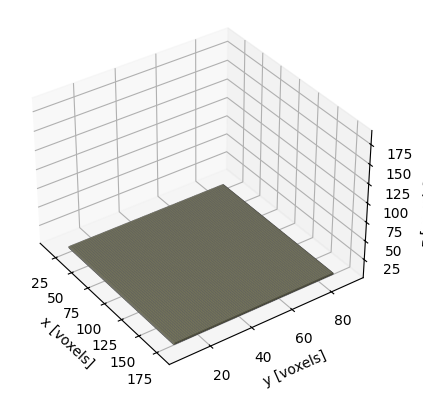

In [ ]:
# SOURCE
if element_num % 2 != 0:
    ids = np.arange(1, element_num + 1) - np.ceil(element_num / 2)
else:
    ids = np.arange(1, element_num + 1) - (element_num + 1) / 2

if not np.isinf(source_focus):
    time_delays = -(np.sqrt((ids * element_pitch) ** 2 + source_focus**2) - source_focus) / c0
    time_delays = time_delays - min(time_delays)
else:
    time_delays = np.zeros(element_num)

source_sig = source_amp * tone_burst(1 / kgrid.dt, source_f0, source_cycles, signal_offset=np.round(time_delays / kgrid.dt).astype(int))
karray = kWaveArray()#bli_tolerance=0.05, upsampling_rate=10)

for ind in range(element_num):
    x_pos = 0 - (element_num * element_pitch / 2 - element_pitch / 2) + ind * element_pitch
    karray.add_rect_element([0, x_pos, kgrid.z_vec[0][0]], element_width, element_length, rotation)

karray.set_array_position(translation, rotation)
source = kSource()
source.p_mask = karray.get_array_binary_mask(kgrid)
voxel_plot(np.single(source.p_mask))
source.p = karray.get_distributed_source_signal(kgrid, source_sig)

In [ ]:
# SENSOR
# sensor_mask = np.zeros((Nx, Ny, Nz))
# sensor_mask[:, Ny // 2, :] = 1
sensor_mask = np.ones((Nx, Ny, Nz))
sensor = kSensor(sensor_mask, record=["p_max"])

In [ ]:
# SIMULATION
simulation_options = SimulationOptions(
    pml_auto=True,
    pml_inside=False,
    save_to_disk=True,
    data_cast="single",
)

execution_options = SimulationExecutionOptions(is_gpu_simulation=False)

sensor_data = kspaceFirstOrder3DC(
    kgrid=kgrid, medium=medium, source=source, sensor=sensor, simulation_options=simulation_options, execution_options=execution_options
)

┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                     16 │
│ Processor name: AMD Ryzen 7 9800X3D 8-Core Processor          │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 128 x 256 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    505 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤
│ Memory a

In [ ]:
# p_max = np.reshape(sensor_data["p_max"], (Nx, Nz), order="F")
p_max = np.reshape(sensor_data["p_max"], (Nx, Ny, Nz), order="F")

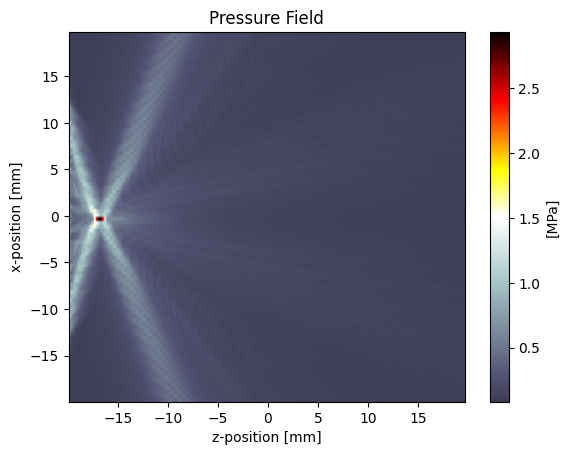

In [ ]:
# VISUALISATION
plt.figure()
plt.imshow(
    1e-6 * p_max[Nx // 2, :, :],
    extent=[1e3 * kgrid.x_vec[0][0], 1e3 * kgrid.x_vec[-1][0], 1e3 * kgrid.z_vec[0][0], 1e3 * kgrid.z_vec[-1][0]],
    aspect="auto",
    cmap=get_color_map(),
)
plt.xlabel("z-position [mm]")
plt.ylabel("x-position [mm]")
plt.title("Pressure Field")
plt.colorbar(label="[MPa]")
plt.show()

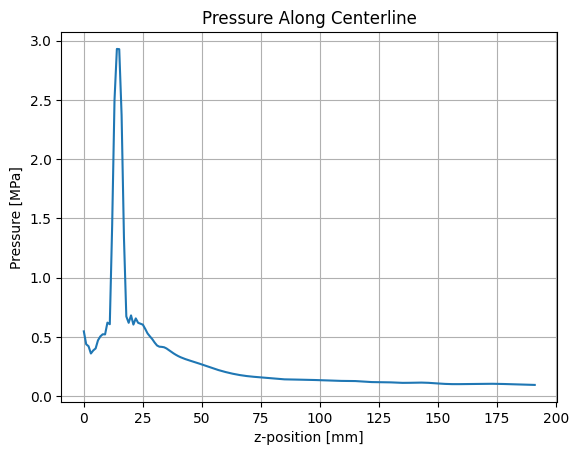

In [ ]:
# Extract centerline data
centerline_index = Ny // 2
centerline_pressure = p_max[Nx // 2, centerline_index, :]
z_axis = 1e3 * kgrid.z_vec[0]  # Convert to mm

# 1D plot
plt.figure()
plt.plot(1e-6 * centerline_pressure)
plt.xlabel('z-position [mm]')
plt.ylabel('Pressure [MPa]')
plt.title('Pressure Along Centerline')
plt.grid(True)
plt.show()


In [ ]:
# np.save('results/unfocused_pressure.npy', centerline_pressure)
np.save('results/focused_pressure.npy', centerline_pressure)

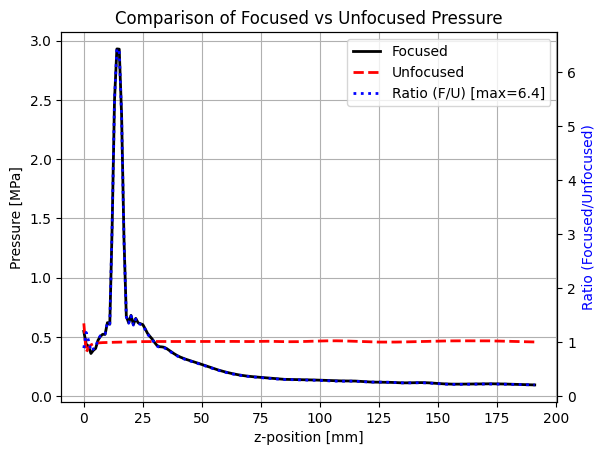

In [ ]:
focused_pressure = np.load('results/focused_pressure.npy')
unfocused_pressure = np.load('results/unfocused_pressure.npy')

# Create figure with primary y-axis
fig, ax1 = plt.subplots()

# Plot pressure data on primary y-axis
ax1.plot(1e-6 * focused_pressure, 'k-', label='Focused', linewidth=2)
ax1.plot(1e-6 * unfocused_pressure, 'r--', label='Unfocused', linewidth=2)
ax1.set_xlabel('z-position [mm]')
ax1.set_ylabel('Pressure [MPa]')
ax1.grid(True)

# Create secondary y-axis for the ratio
ax2 = ax1.twinx()
ratio = focused_pressure / unfocused_pressure
max_ratio = np.max(ratio)
ax2.plot(ratio, 'b:', label=f'Ratio (F/U) [max={max_ratio:.1f}]', linewidth=2)
ax2.set_ylabel('Ratio (Focused/Unfocused)', color='b')

# Title and legend
plt.title('Comparison of Focused vs Unfocused Pressure')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()